In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import networkx as nx

from matplotlib import pyplot as plt
from sklearn import model_selection

import codecs
import json
import os

In [2]:
IMPORT = True
EXPORT = True
DISPLAY = True
VERBOSE = False
DATA_DIR = "new_data"
SEED = 221

In [3]:
def get_datasets(type='medium'):
    if type not in ['medium', 'all', 'mini']:
        raise Exception("Invalid type!")
        
    train_df = pd.read_csv(DATA_DIR + f'/train_{type}.csv').set_index("request_id")
    dev_df = pd.read_csv(DATA_DIR + f'/val_{type}.csv').set_index("request_id")
    return train_df, dev_df

In [4]:
train_df, dev_df = get_datasets('medium')

FileNotFoundError: File b'new_data/train_medium.csv' does not exist

In [5]:
df = train_df
G = nx.Graph()
import ast

for i, row in df.iterrows():
    username = row.requester_username
    pizza = row.requester_received_pizza
    subreddits = row.requester_subreddits_at_request
    for subreddit in ast.literal_eval(str(subreddits)):
        G.add_edge(username, subreddit)

NameError: name 'train_df' is not defined

In [204]:
# ## Connectivity
# One more preprocessing step - get rid of extra disconnected components
nx.number_connected_components(G)
for component in nx.connected_components(G):
    print(len(component))
    if len(component) < 10:
        print(component)
print(len(G))
G = G.subgraph(next(nx.connected_components(G))).copy()
print(len(G))

2271
2
{'SlenderMan', 'caarl'}
3
{'IowaCity', 'lincoln', 'gnidaol123'}
2276
2271


In [205]:
pos = nx.drawing.layout.bipartite_layout(G, list(df.requester_username))

In [206]:
requesters = list(df.requester_username.unique())
subreddits = [n for n in G.nodes() if n not in requesters]

In [207]:
len(requesters), len(subreddits), len(G.nodes())

(330, 1985, 2271)

## Bipartite graph starting

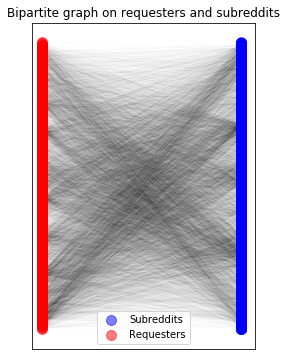

In [219]:
plt.figure(figsize=(4, 6))
nx.draw_networkx_nodes(G, nodelist=subreddits, pos=pos, alpha=0.5, node_size=100, label='Subreddits', node_color='b')
nx.draw_networkx_nodes(G, nodelist=requesters, pos=pos, alpha=0.5, node_size=100, label='Requesters', node_color='r')
nx.draw_networkx_edges(G, pos=pos, linewidths=0.001, alpha=0.01, node_size=100)
plt.title("Bipartite graph on requesters and subreddits")
plt.legend()
plt.show()

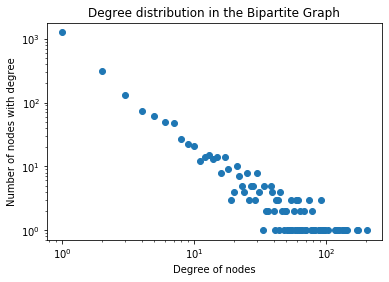

In [209]:
# ## Degree analysis
import collections
degrees = G.degree
#degrees = {k:v for (k, v) in dict(degrees).items() if k in requesters}
degree_count = dict(collections.Counter(dict(degrees).values()))

if (DISPLAY):
    plt.loglog()
    plt.plot(list(degree_count.keys()), list(degree_count.values()), linestyle=' ', marker='o')
    plt.title("Degree distribution in the Bipartite Graph")
    plt.xlabel("Degree of nodes")
    plt.ylabel("Number of nodes with degree")
    plt.show()

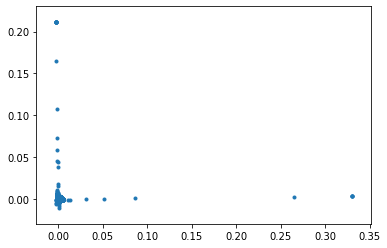

In [210]:
# ## Spectral analysis
node_ordering = G.nodes()
Adj = nx.linalg.adjacency_matrix(G)


# Spectral Clustering
from sklearn.manifold import SpectralEmbedding
model = SpectralEmbedding(n_components=2,
                              affinity='precomputed',
                              random_state=SEED,
                              n_neighbors=None,
                              n_jobs=None)
spectral_embedding = model.fit_transform(Adj.toarray())

if (DISPLAY):
    # plot Spectral Clustering
    plt.scatter(spectral_embedding[:,0], spectral_embedding[:, 1])
    plt.show()

In [211]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, perplexity=75.0, early_exaggeration=12.0,
             learning_rate=200.0, n_iter=1000, n_iter_without_progress=300,
             min_grad_norm=1e-07, random_state=SEED)
embedding = model.fit_transform(spectral_embedding)


embedding = pd.DataFrame(embedding, index=node_ordering)
embedding.head()

,0,1
LessThanLaura,27.781099,-29.972647
90scartoons,27.631620,-30.021955
AskReddit,25.519873,-6.508165
CatTraining,27.631620,-30.021955
GossipGirl,27.631620,-30.021955


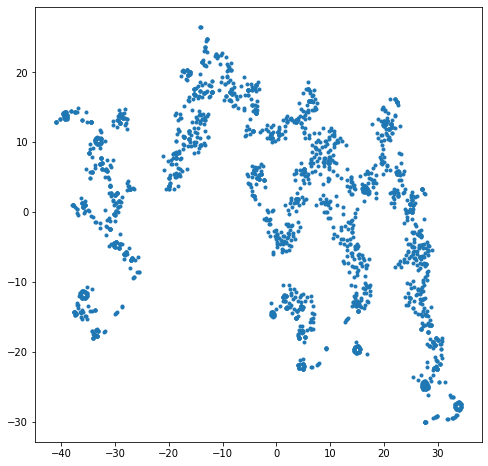

In [212]:
if (DISPLAY):
    # plot t-SNE
    plt.figure(figsize=(8, 8))
    plt.scatter(embedding.iloc[:,0], embedding.iloc[:, 1])
    plt.show()

/home/clare/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/home/clare/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  import sys


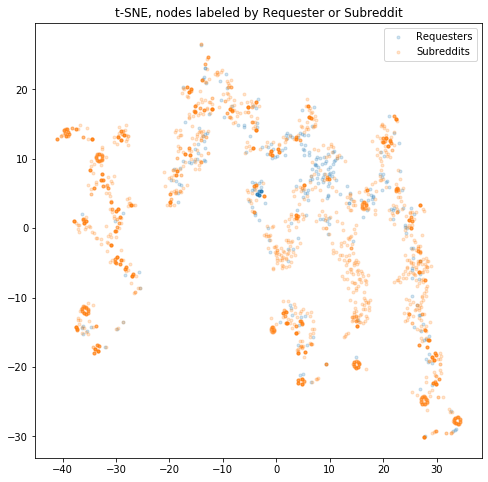

In [213]:
if (DISPLAY):
    plt.figure(figsize=(8, 8))
    plt.rcParams["scatter.marker"] = '.'
    group1 = requesters
    group2 = subreddits
    plt.scatter(embedding.loc[group1].iloc[:,0],
                embedding.loc[group1].iloc[:,1], alpha=0.2, label="Requesters", marker='.')
    plt.scatter(embedding.loc[group2].iloc[:,0],
                embedding.loc[group2].iloc[:,1], alpha=0.2, label="Subreddits", marker='.')
    plt.legend()
    plt.title("t-SNE, nodes labeled by Requester or Subreddit")
    plt.show()

In [214]:
adj_features = pd.DataFrame(Adj.toarray(), index=node_ordering, columns=node_ordering)

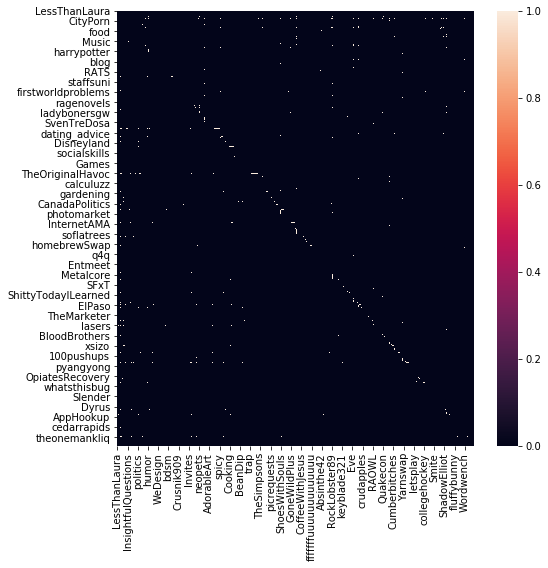

In [215]:
plt.figure(figsize=(8, 8))
sns.heatmap(adj_features)

/home/clare/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


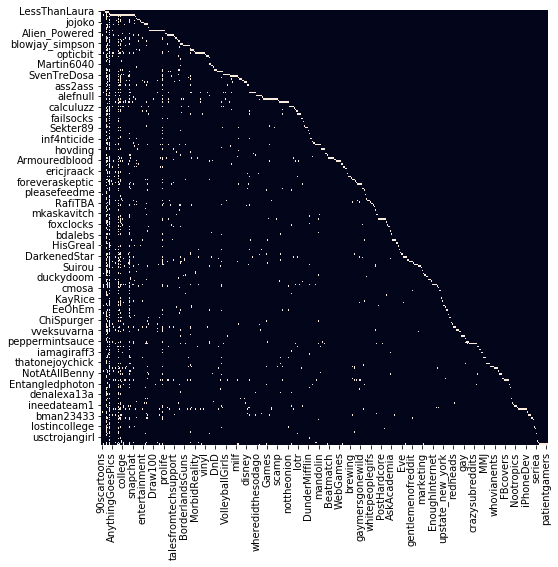

In [217]:
plt.figure(figsize=(8, 8))
sns.heatmap(adj_features.loc[requesters][subreddits].dropna(axis=0), cbar=False)

In [196]:
X = adj_features.loc[df.requester_username][subreddits]
X['received_pizza'] = df.set_index('requester_username').requester_received_pizza
X.shape, y.shape

/home/clare/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


((110, 888), (286,))

In [200]:
dat = X.dropna(axis=0).dropna(how='all', axis=1)

In [114]:
lr = sklearn.linear_model.LogisticRegression()

In [201]:
X_dev = dat[[col for col in dat.columns if col != 'received_pizza']]
y_dev = dat['received_pizza']

In [181]:
X_train = dat[[col for col in dat.columns if col != 'received_pizza']]
y_train = dat['received_pizza']

In [202]:
lr.fit(X_train, y_train)
lr.score(X_dev, y_dev)

/home/clare/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: X has 887 features per sample; expecting 1985